---

## FiandoraHack - Corridor Battle

In [1]:
import gym
import time
import matplotlib.pyplot as plt
from pyswip import Prolog
from utils_corridor import process_state, perform_action, show_match

Define some parameters to customize the experiments.

In [2]:
NUM_EPISODES = 5
MAX_STEPS = 100
PATH = 'kb_corridor.pl'

In [3]:
import minihack
from minihack import LevelGenerator
from nle import nethack

map = """
-----       ----------------------
|...|       |....................|
|....#######.....................|
|...|       |....................|
-----       ----|.....|----------|
       ---------|.....|----------|
       |.........................|
|------|...|...|.................|
|..........|...|.................|
|..........|...|.................|
|----------|...|--|..............|
|.................|..............|
|.................|..............|
|------------.....|..............|
|...........|....................|
|...........|....................|
|...........|....................|
|...........|....................|
|................................|
|...........|....................|
----------------------------------
"""

lvl_gen = LevelGenerator(map=map, lit=False)
lvl_gen.set_start_pos((1, 1))
lvl_gen.add_monster(name="giant rat", place=(27, 1))
lvl_gen.add_monster(name="giant rat", place=(26, 1))
lvl_gen.add_monster(name="giant rat", place=(27, 2))
lvl_gen.add_monster(name="giant rat", place=(26, 2))
lvl_gen.add_monster(name="giant rat", place=(27, 3))
lvl_gen.add_monster(name="giant rat", place=(26, 3))
lvl_gen.add_door("closed", place=(12,18))
lvl_gen.add_object(name='skeleton key', symbol='(', place=(3,8))
lvl_gen.add_goal_pos((16, 2)) #TODO: change


MOVE_ACTIONS = tuple(nethack.CompassDirection)
NAVIGATE_ACTIONS = MOVE_ACTIONS + (
    nethack.Command.PICKUP,
    nethack.Command.OPEN
)

env = gym.make("MiniHack-Skill-Custom-v0",
               character = "rog-hum-cha-mal",
               observation_keys=('screen_descriptions','chars','glyphs','inv_strs','blstats','message','pixel','pixel_crop'),
               des_file = lvl_gen.get_des(),
               actions = NAVIGATE_ACTIONS)
obs=env.reset() # each reset generates a new environment instance
env.render()


Hello Agent, welcome to NetHack!  You are a chaotic male human Rogue.           
                      ---                                                       
                      |@.                                                       
                      |..                                                       
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           

In [4]:
obs = env.reset()
env.render()


Hello Agent, welcome to NetHack!  You are a chaotic male human Rogue.           
                      ---                                                       
                      |@.                                                       
                      |..                                                       
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           

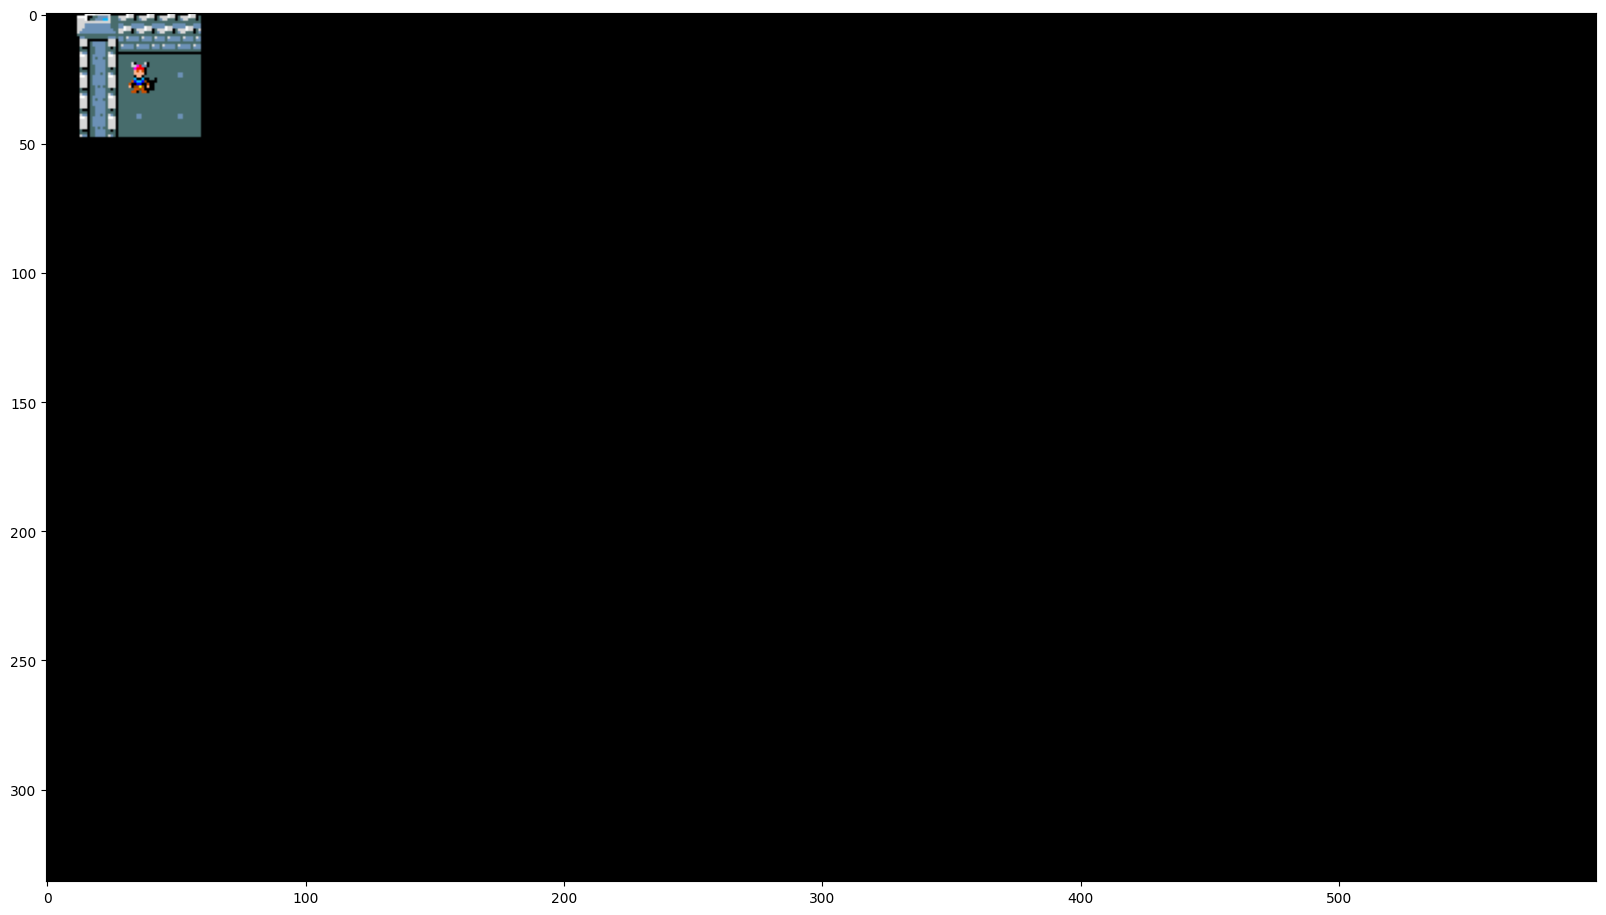

In [5]:
plt.figure(figsize=(20, 16))
plt.imshow(obs['pixel'][:, 340:940])

Initialize the knowledge base.

In [6]:
KB = Prolog()
KB.consult(PATH)

#### Main code
- Perform `NUM_EPISODES` experiences in the environment.
- Use `Prolog` to define the axioms and choose the action to perform.

KeyboardInterrupt: 

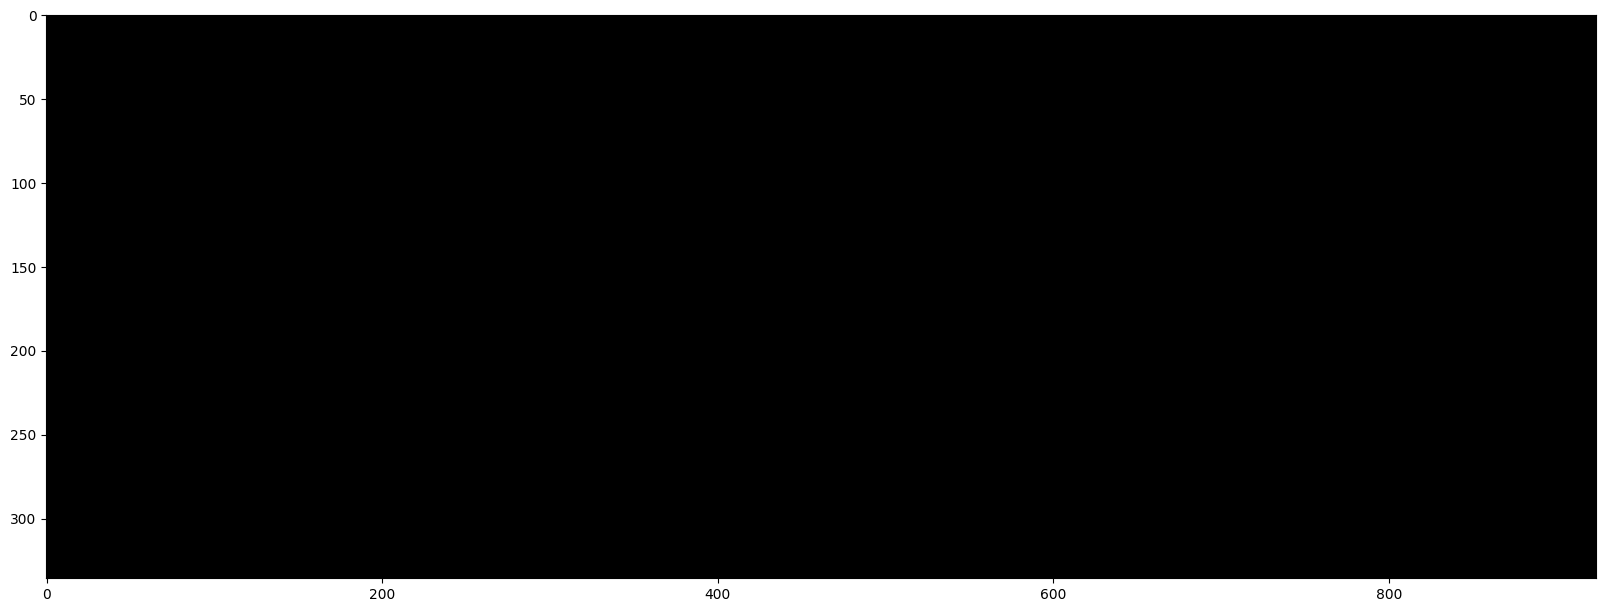

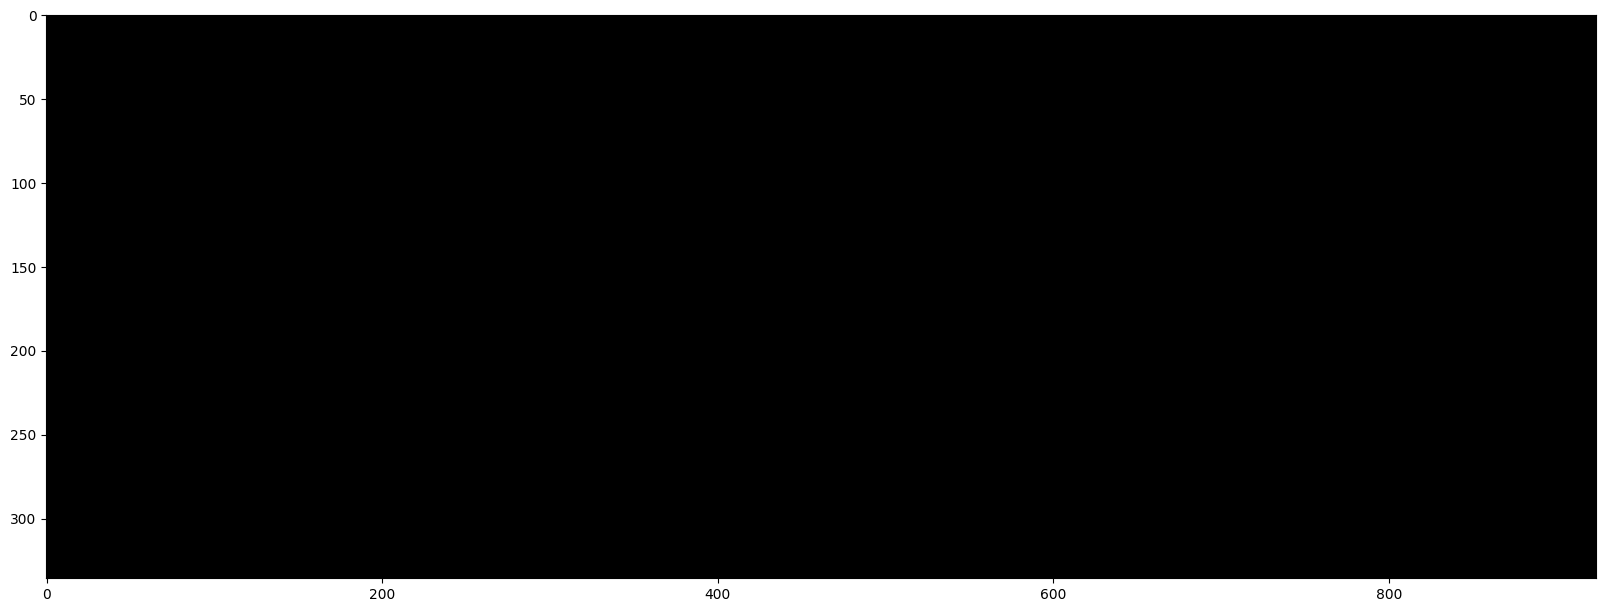

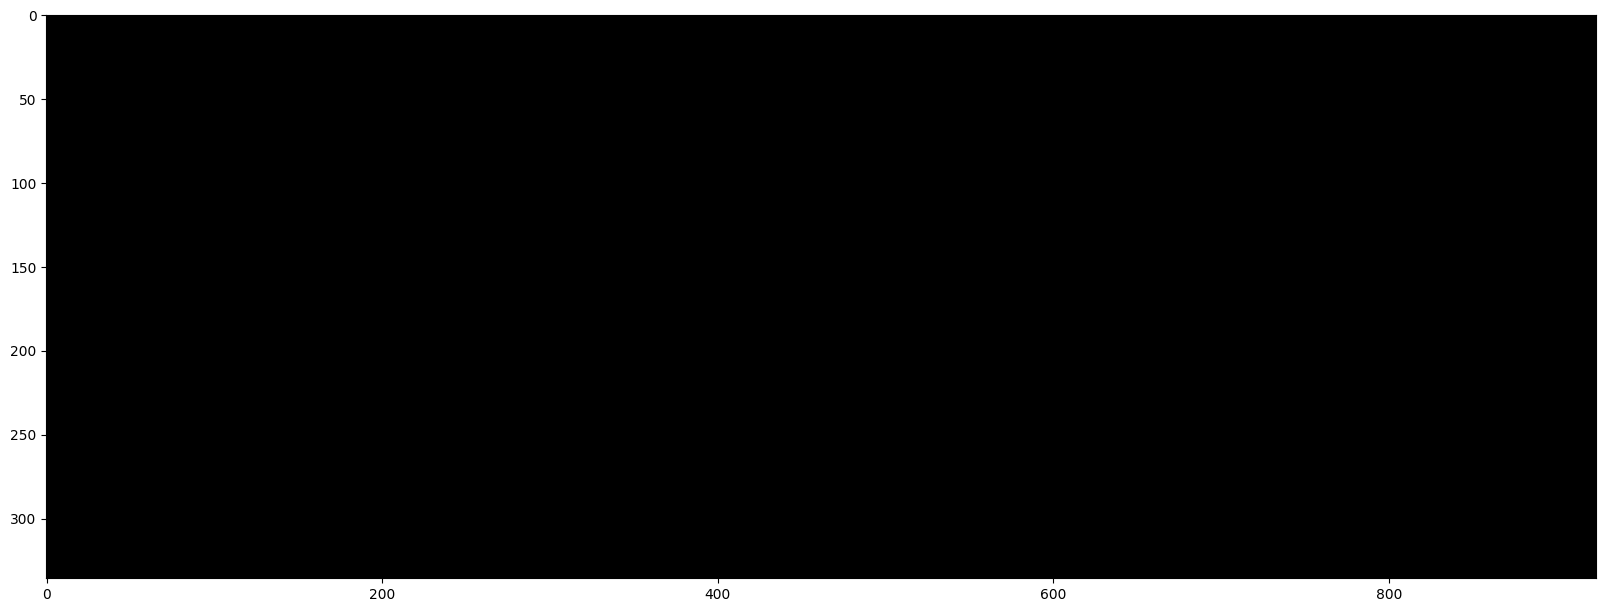

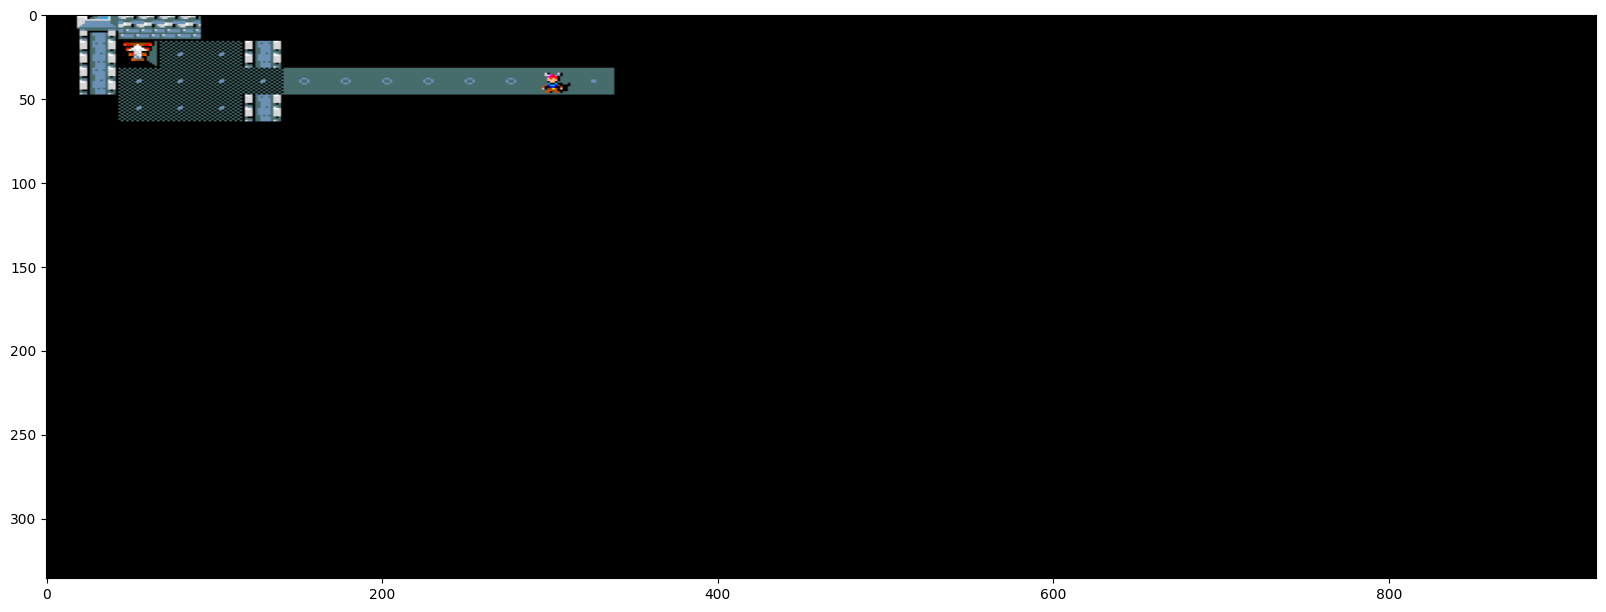

In [7]:
def print_debug(content):
    with open("output.txt", 'a') as file:
        file.write(content)

rewards = []
for episode in range(NUM_EPISODES):
    # count the number of steps of the current episode
    steps = 0
    # store the cumulative reward
    reward = 0.0
    # collect obs['pixel'] to visualize
    ep_states = []
    ep_messages = []
    #ep_blstats = [] #CNG: line added"""

    obs = env.reset()

    ep_states.append(obs['pixel'])

    message = bytes(obs['message']).decode('utf-8').rstrip('\x00')
    ep_messages.append(message)


    """ep_blstats.append(obs['blstats']) #CNG: line added
    print(obs['blstats']) #CNG: line added
    time.sleep(5.0) #CNG: line added"""

    done = False



    KB.retractall("inertia_dir(_)")
    KB.retractall("corridor_type(_)")

    KB.retractall("last_extreme_rel(_)")
    KB.retractall("last_extreme_abs(_)")

    KB.retractall("place(_)")

    KB.retractall("room_temp(_)")
    KB.asserta("room_temp(initial_room)")

    
    KB.retractall("num_rats_left(_)")
    KB.asserta("num_rats_left(6)")

    KB.retractall("on_agent_dir(_,_)")

    KB.retractall("already_in_corridor(_)")
    KB.asserta("already_in_corridor(false_)")
    
    corridor_start_found = False

    
    KB.retractall("position(corridor_start,_,_)") #TODO: remove
    KB.retractall("position(final_goal_position,_,_)") #TODO: remove
    KB.asserta(f"position(corridor_start, 2, 27)")

    '''
    i = 0
    while(i<21 and corridor_start_found==False):
        j = 0
        while(j<79 and corridor_start_found==False):
            if obs['chars'][i][j] == ord('#'):
                corridor_start_found = True
                KB.asserta(f"position(corridor_start, {i}, {j})")
                print_debug("*************** CORRIDORSTART" + str(i) + str(j))
            j+=1
        i+=1
    '''

    # Main loop
    while not done and steps < MAX_STEPS:
        # Get the observation from the env and assert the facts in the kb 
        process_state(obs, KB)

        # Query Prolog
        # Run the inference and get the action to perform
        # Get the first answer from Prolog -> the top-priority action
        try:
            action = list(KB.query('action(X)'))[0]
            action = action['X']
            # print(f'>> Current action from Prolog: {action}')
        except Exception as e:
            action = None

        # Perform the action in the environment
        print("XXX; action selected: " + str(action))
        if action:
            obs, reward, done, info = perform_action(action, env)
            ep_states.append(obs['pixel'])

            message = bytes(obs['message']).decode('utf-8').rstrip('\x00')
            ep_messages.append(message)

            """ep_blstats.append(obs['blstats']) #CNG: line added
            print(obs['blstats']) #CNG: line added
            time.sleep(5.0) #CNG: line added
            #print(ep_blstats[0]) #CNG: line added"""
            # env.render()
        else:
            print("ERROR: impossible to perform any action. Please check assertions and definitions in KB.")
            break

        steps += 1

    # Display game with interface
    show_match(ep_states, ep_messages)
    # Print information about the ended episode
    print(f'Episode {episode} - {steps} steps')
    print(f'End status: {info["end_status"].name}')
    print(f'Final reward: {reward}')
    time.sleep(0.75)

    rewards.append(reward)

    # reset the environment and retract axioms that may cause errors
    obs = env.reset()


print(f'After {NUM_EPISODES} episodes, mean return is {sum(rewards)/NUM_EPISODES}')
print("The rewards of the episodes are:", rewards)

---

## At home

You can play with the rules (e.g. change the order) and observe how agent's behaviour change.

In particular try to add the monster `giant mummy` in the environment and define the goal as _kill the monster_. Be aware that it can be killed only with the `tsurugi` weapon!